# Reproduce chi2 spectrum fit

I tried to reproduce the spectral fit I made with Christoph a few weeks ago using a new source.

## Load Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u

In [2]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()

# This time I will pick source MSH 15-52 because it should make a nice plot
source = cat['MSH 15-52'] # a.k.a. 3FGL J1514.0-5915e
data = source.flux_points.table

# Flux units
data['dnde'] = data['dnde'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data['dnde'] * (data['flux_errn'] / data['flux'])
data['dnde_err'] = dnde_err.to(data['dnde'].unit)

data.info()

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             MeV     0
     e_min float64             MeV     0
     e_max float64             MeV     0
      flux float32     1 / (cm2 s)     0
 flux_errn float32     1 / (cm2 s)     4
 flux_errp float32     1 / (cm2 s)     4
     eflux float32   erg / (cm2 s)     0
eflux_errn float32   erg / (cm2 s)     4
eflux_errp float32   erg / (cm2 s)     4
      dnde float64 1 / (cm2 MeV s)     0
  dnde_err float64 1 / (cm2 MeV s)     4


In [3]:
cols = ['e_ref', 'dnde', 'dnde_err']
data[cols]

e_ref,dnde,dnde_err
MeV,1 / (cm2 MeV s),1 / (cm2 MeV s)
float64,float64,float64
173.205080757,2.83701868472e-11,inf
547.722557505,4.65581755264e-12,inf
1732.05080757,7.61241691909e-13,inf
5477.22557505,1.24927000409e-13,inf
31622.7766017,6.5243766732e-15,1.11852487999e-15


In [4]:
pprint(source.spectral_model.parameters)
print(source.energy_range)

{'amplitude': <Quantity 1.7884677029275653e-12 1 / (cm2 MeV s)>,
 'index': <Quantity 1.5713396072387695>,
 'reference': <Quantity 1000.0 MeV>}
[    100.  100000.] MeV


## Plot data and model

<Container object of 3 artists>

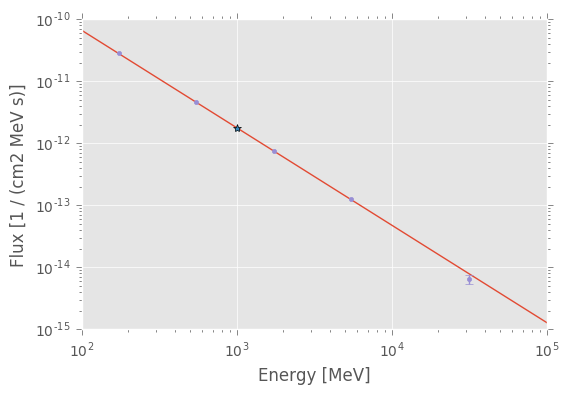

In [12]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

source.spectral_model.plot(source.energy_range, **opts)
# ^What's the red curve on the plot? Isn't that the model?

p = source.spectral_model.parameters
e_ref = p['reference']
amp = p['amplitude']
idx = p['index']

# Plot reference point
plt.plot(e_ref.value, amp.value, '*')

# Plot all data from source's FluxPoints
plt.errorbar(x=data['e_ref'],
             y = data['dnde'],
             yerr = data['dnde_err'],
             fmt='.'
            )

# On Axel's plot (https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS%20J1514-591_3FGL%20J1514.0-5915e_sed.png),
# the slope for 3FGL data is positive. Why is it negative here?

 ## Likelihood function - chi2
 
 We will do a PL model and not an ECPL model this time, because "p" has no attribute for energy cutoff.

In [6]:
source.spectral_model(e_ref)

<Quantity 1.7884677029275653e-12 1 / (cm2 MeV s)>

In [7]:
# The same model as defined in Gammapy
def dnde_model_pl(energy, amplitude, index, reference):
    return amplitude * (energy / reference) ** (-index)

# How would I use an ECPL model if I wanted to, if "source.spectral_model"
# has no perameter for e_cut?

# Defining chi2 function for this source
def chi2(amplitude, index, energy_cut):
    
    dnde_model = dnde_model_pl(
        energy=data['e_ref'],
        amplitude=amplitude,
        index=index,
        reference=1000.0 # <-- this is e_ref minus the units
    ) 
    
    chi = (data['dnde'] - dnde_model) / data['dnde_err']
    return np.sum(chi ** 2)

In [8]:
# Test one example evaluation - we want the same result as source.spectral_model
dnde_model_pl(
    energy=e_ref,
    amplitude=amp,
    index=idx,
    reference=e_ref
)

<Quantity 1.7884677029275653e-12 1 / (cm2 MeV s)>

## ML fit with Minuit

Maximum likelihood (ML) analysis.

In [10]:
from iminuit import Minuit

pars = dict(amplitude=1.7884677029275653e-12, #amp value
            index=1.5713396072387695          #idx value
            )

m = Minuit(chi2, **pars)
m.migrad()

# Why did this fail below?

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter energy_cut does not have initial value. Assume 0.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter energy_cut is floating but does not have initial step size. Assume 1.


FCN = 3.784860260022252e-09 
 TOTAL NCALL = 50 
 NCALLS = 50 
 
 
 EDM = 3.141305094396968e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,1.61406e-12,1.41421,0,0,,,
2,index,1.59558,0.0496355,0,0,,,
3,energy_cut,0,1.41421,0,0,,,


({'fval': 3.784860260022252e-09, 'has_valid_parameters': True, 'up': 1.0, 'has_reached_call_limit': False, 'has_made_posdef_covar': False, 'has_accurate_covar': False, 'has_posdef_covar': False, 'hesse_failed': True, 'nfcn': 50, 'is_above_max_edm': False, 'has_covariance': True, 'is_valid': False, 'edm': 3.141305094396968e-09},
 [{'has_upper_limit': False, 'upper_limit': 0.0, 'number': 0, 'is_const': False, 'value': 1.6140580181445098e-12, 'lower_limit': 0.0, 'is_fixed': False, 'has_lower_limit': False, 'name': 'amplitude', 'has_limits': False, 'error': 1.4142135623730951},
  {'has_upper_limit': False, 'upper_limit': 0.0, 'number': 1, 'is_const': False, 'value': 1.5955836898610853, 'lower_limit': 0.0, 'is_fixed': False, 'has_lower_limit': False, 'name': 'index', 'has_limits': False, 'error': 0.04963554594773415},
  {'has_upper_limit': False, 'upper_limit': 0.0, 'number': 2, 'is_const': False, 'value': 0.0, 'lower_limit': 0.0, 'is_fixed': False, 'has_lower_limit': False, 'name': 'energy